# MarketView

**MarketView** is a comprehensive predictive model that combines stock price data with tweet sentiment analysis to forecast market trends. By incorporating technical indicators and real-time social media sentiment, it provides deeper insights into stock movements, helping users make informed investment decisions.

# Introduction


Generative Adversarial Networks (GANs) have shown impressive results in creating realistic images, videos, and text. However, their effectiveness for stock price forecasting, especially with volatile stocks, remains debated. Traditionally used for generating media, GANs haven't been extensively tested on time series data like stock prices, which are influenced by market volatility and social factors.

Recently, data scientists have begun experimenting with GANs for stock prediction, and some have seen promising outcomes. Additionally, analyzing news and social media is becoming more common in this field. So, why not combine these approaches?

In this notebook, I build a model to predict Amazon (AMZN) stock prices by integrating historical data, technical indicators, and external factors like trader sentiment and brand reputation from social media.

# Table of contents
1. [Import packages](#section-one)
1. [Get weekly sentiment for stock ticker](#section-two)
1. [Get final dataset for training](#section-three)
1. [Build GAN model](#section-four)
1. [Train and test model](#section-five)
1. [Conclusions](#section-six)

<a id="section-one"></a>
# Import packages

In [95]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model # Changed import statement to use tensorflow.keras.utils
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

<a id="section-two"></a>
# Get weekly sentiment for stock ticker

Stock prices are influenced by more than just historical data. A single online post can shift the market's direction in a single day, potentially triggering events like a market crash. Examples such as Elon Musk's tweets, the coronavirus pandemic, and the Russian invasion of Ukraine highlight this. That's why we’ll incorporate an essential external factor: the sentiment of stock market participants. In this notebook, we'll analyze the tone (sentiment) of Twitter posts as a key indicator.










In [56]:
stock_name = 'AMZN'

In [57]:
all_tweets = pd.read_csv('/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_tweets.csv')

In [58]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [59]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc."
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc."
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc."
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc."
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc."


In [60]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",,,,


To calculate sentiment (polarity) scores, we use the **VADER (Valence Aware Dictionary for Sentiment Reasoning)** model. VADER is a text sentiment analysis tool that accounts for both the polarity (positive/negative) and intensity (strength) of emotions. It’s part of the NLTK package and works directly on unlabeled text data.

VADER's sentiment analysis is based on a dictionary that links lexical features to emotion intensities, known as sentiment scores. The overall sentiment score of a text is determined by summing the intensity of each word in the text.

In [61]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.T.items(): # Use items() instead of iteritems()
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (sent_df.loc[indx, 'Tweet']) # Changed indexx to indx
        print (indx)
        break

CPU times: user 2.54 s, sys: 14.3 ms, total: 2.55 s
Wall time: 2.55 s


In [62]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",-0.0772,0.084,0.841,0.075
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",0.25,0.158,0.684,0.158
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",-0.3182,0.164,0.728,0.108
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",0.2382,0.065,0.851,0.083
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",0.7783,0.0,0.799,0.201


In [63]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [64]:
sent_df.head()

,Date,Tweet,sentiment_score
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,-0.0772
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,-0.3182
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,0.2382
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,0.7783


In [65]:
twitter_df = sent_df.groupby([sent_df['Date']])['sentiment_score'].mean() # Select the numeric column 'sentiment_score' to calculate the mean
print(twitter_df.shape)

(365,)


Average polarity scores of all tweets about a cartain stock ticker for each day:

In [66]:
twitter_df.head()

,sentiment_score
Date,
2021-09-30,0.24648
2021-10-01,0.359338
2021-10-02,-0.0007
2021-10-03,0.8344
2021-10-04,0.25865


<a id="section-three"></a>
# Get final dataset for training

In [67]:
all_stocks = pd.read_csv('/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [68]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [69]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [70]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.24648
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359338
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.25865
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.0455
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.1943


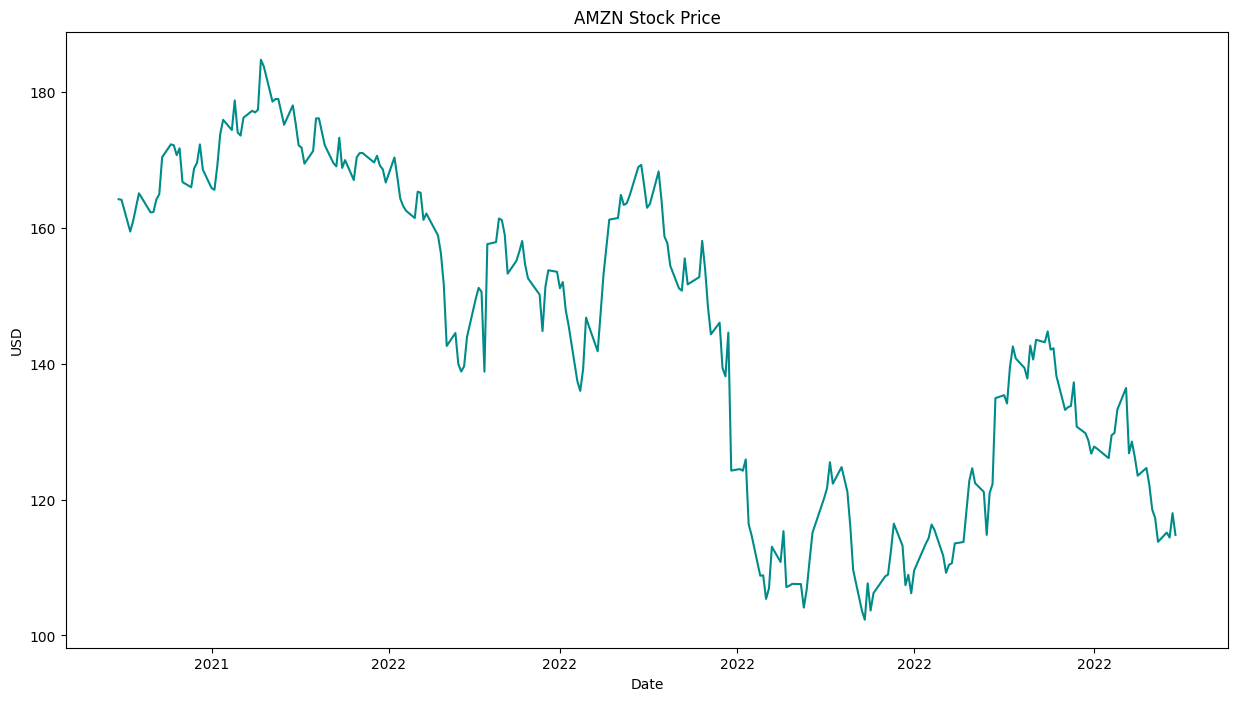

In [71]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

### Adding technical indicators

To help the network understand the bigger picture of the market we add different technical indicators to the training data, such as moving averages, Bollinger bands etc., which describe the development of stock price not only for the current day, but for the past week or more.

**MA(7)** refers to the Moving Average calculated over the past 7 days, while **MA(20)** represents the Moving Average over the past 20 days.

**EMA** stands for Exponential Moving Average, and it can be calculated using the formula:

**EMA_t** = Pclose + (EMA_t-1 * (100 - P))
Bollinger Bands are determined as follows:

**Middle line**: stdev(MA(20))
**Upper band**: MA(20) + 2stdev(MA(20))
**Lower band**: MA(20) - 2stdev(MA(20))

In [72]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [73]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.00145,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


In [74]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

Moving Averages for our data:

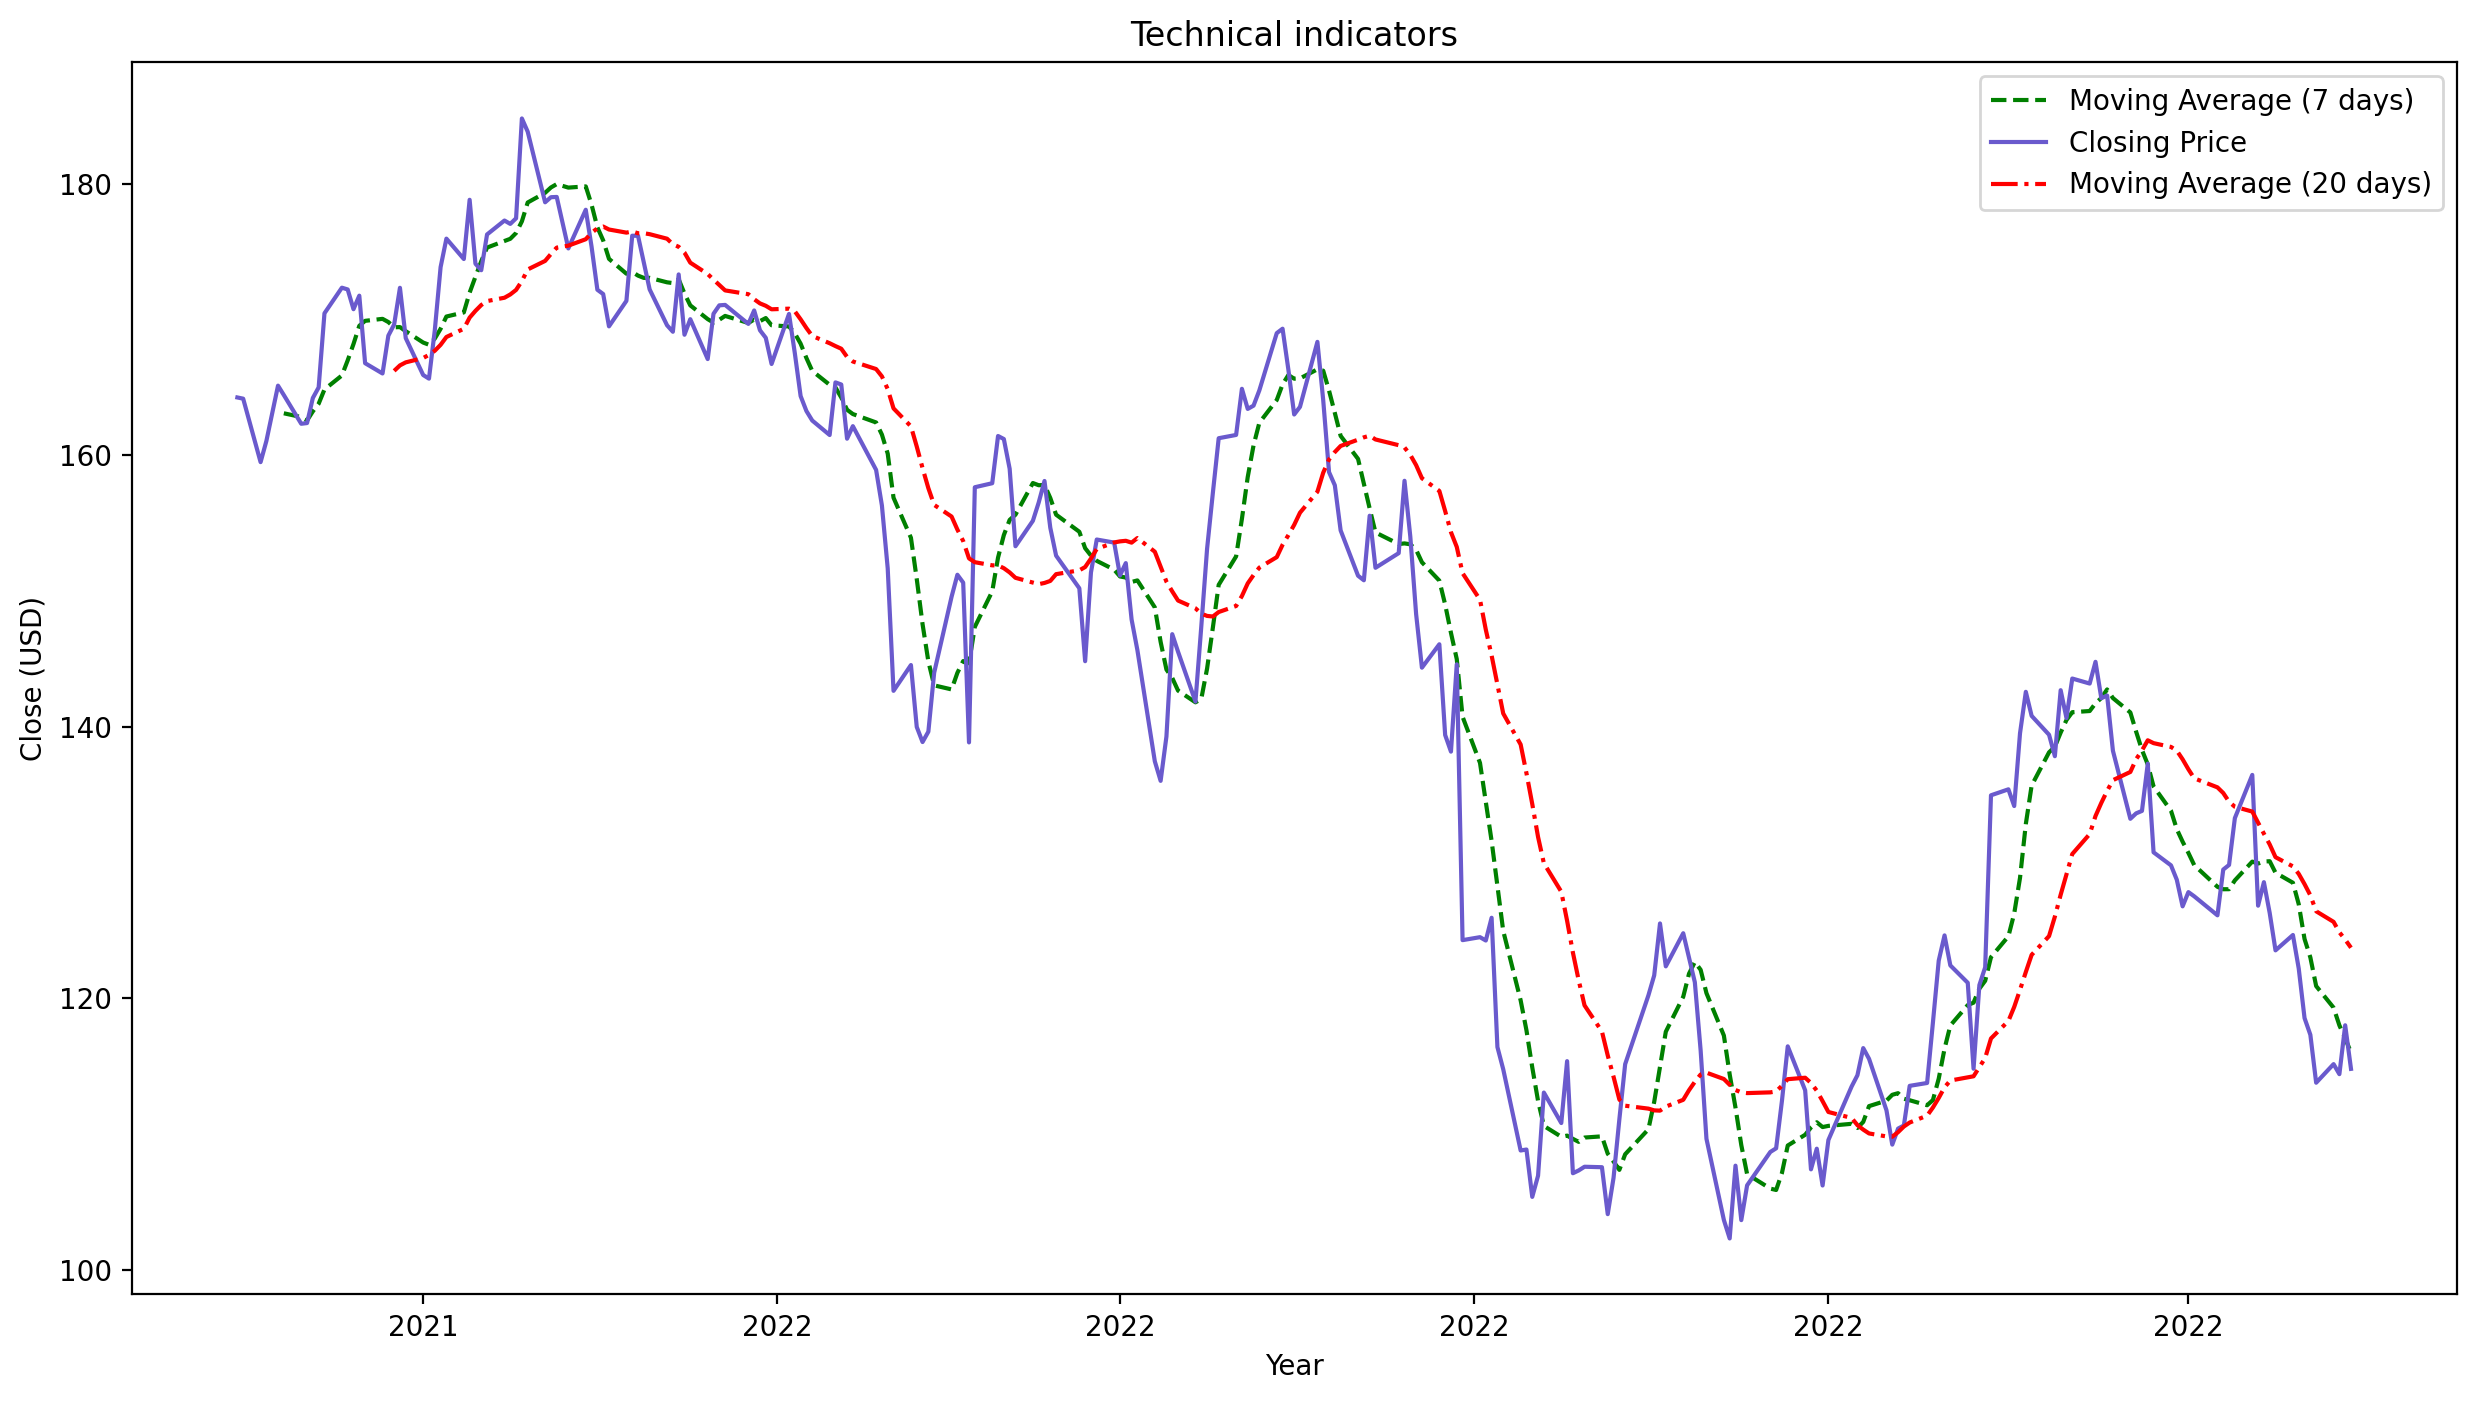

In [75]:
tech_ind(tech_df)

In [76]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [77]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [78]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [79]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [80]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [81]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [82]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [83]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

<a id="section-four"></a>
# Build GAN model

 The generator has 5 LSTM blocks and the discriminator has 5 convolutional and 3 dense layers with sigmoid activation function.
 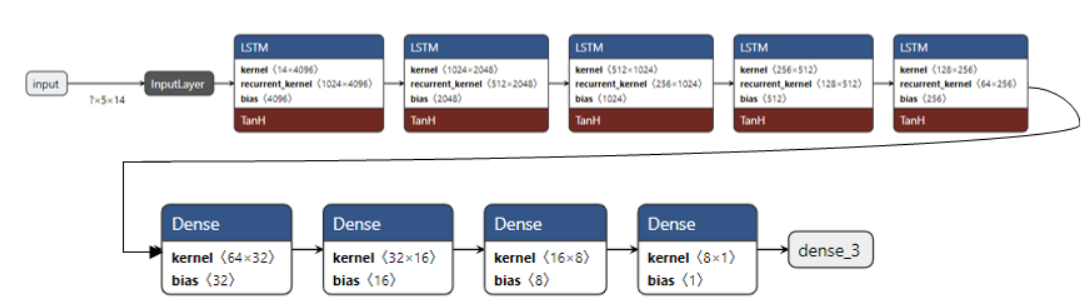

Discriminator model
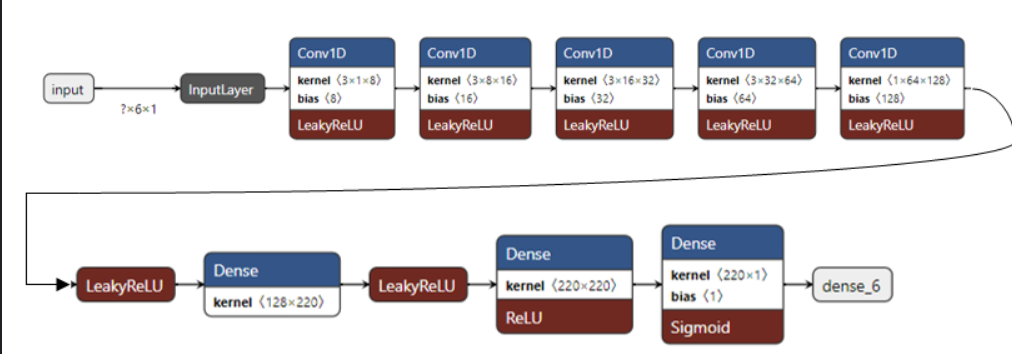

In [84]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [85]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

Now we define loss functions for our models. We will use BinaryCrossEntropy loss for both models:

In [86]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [87]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [88]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [89]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [90]:
## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [91]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()


In [92]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Changed lr to learning_rate
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Changed lr to learning_rate

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

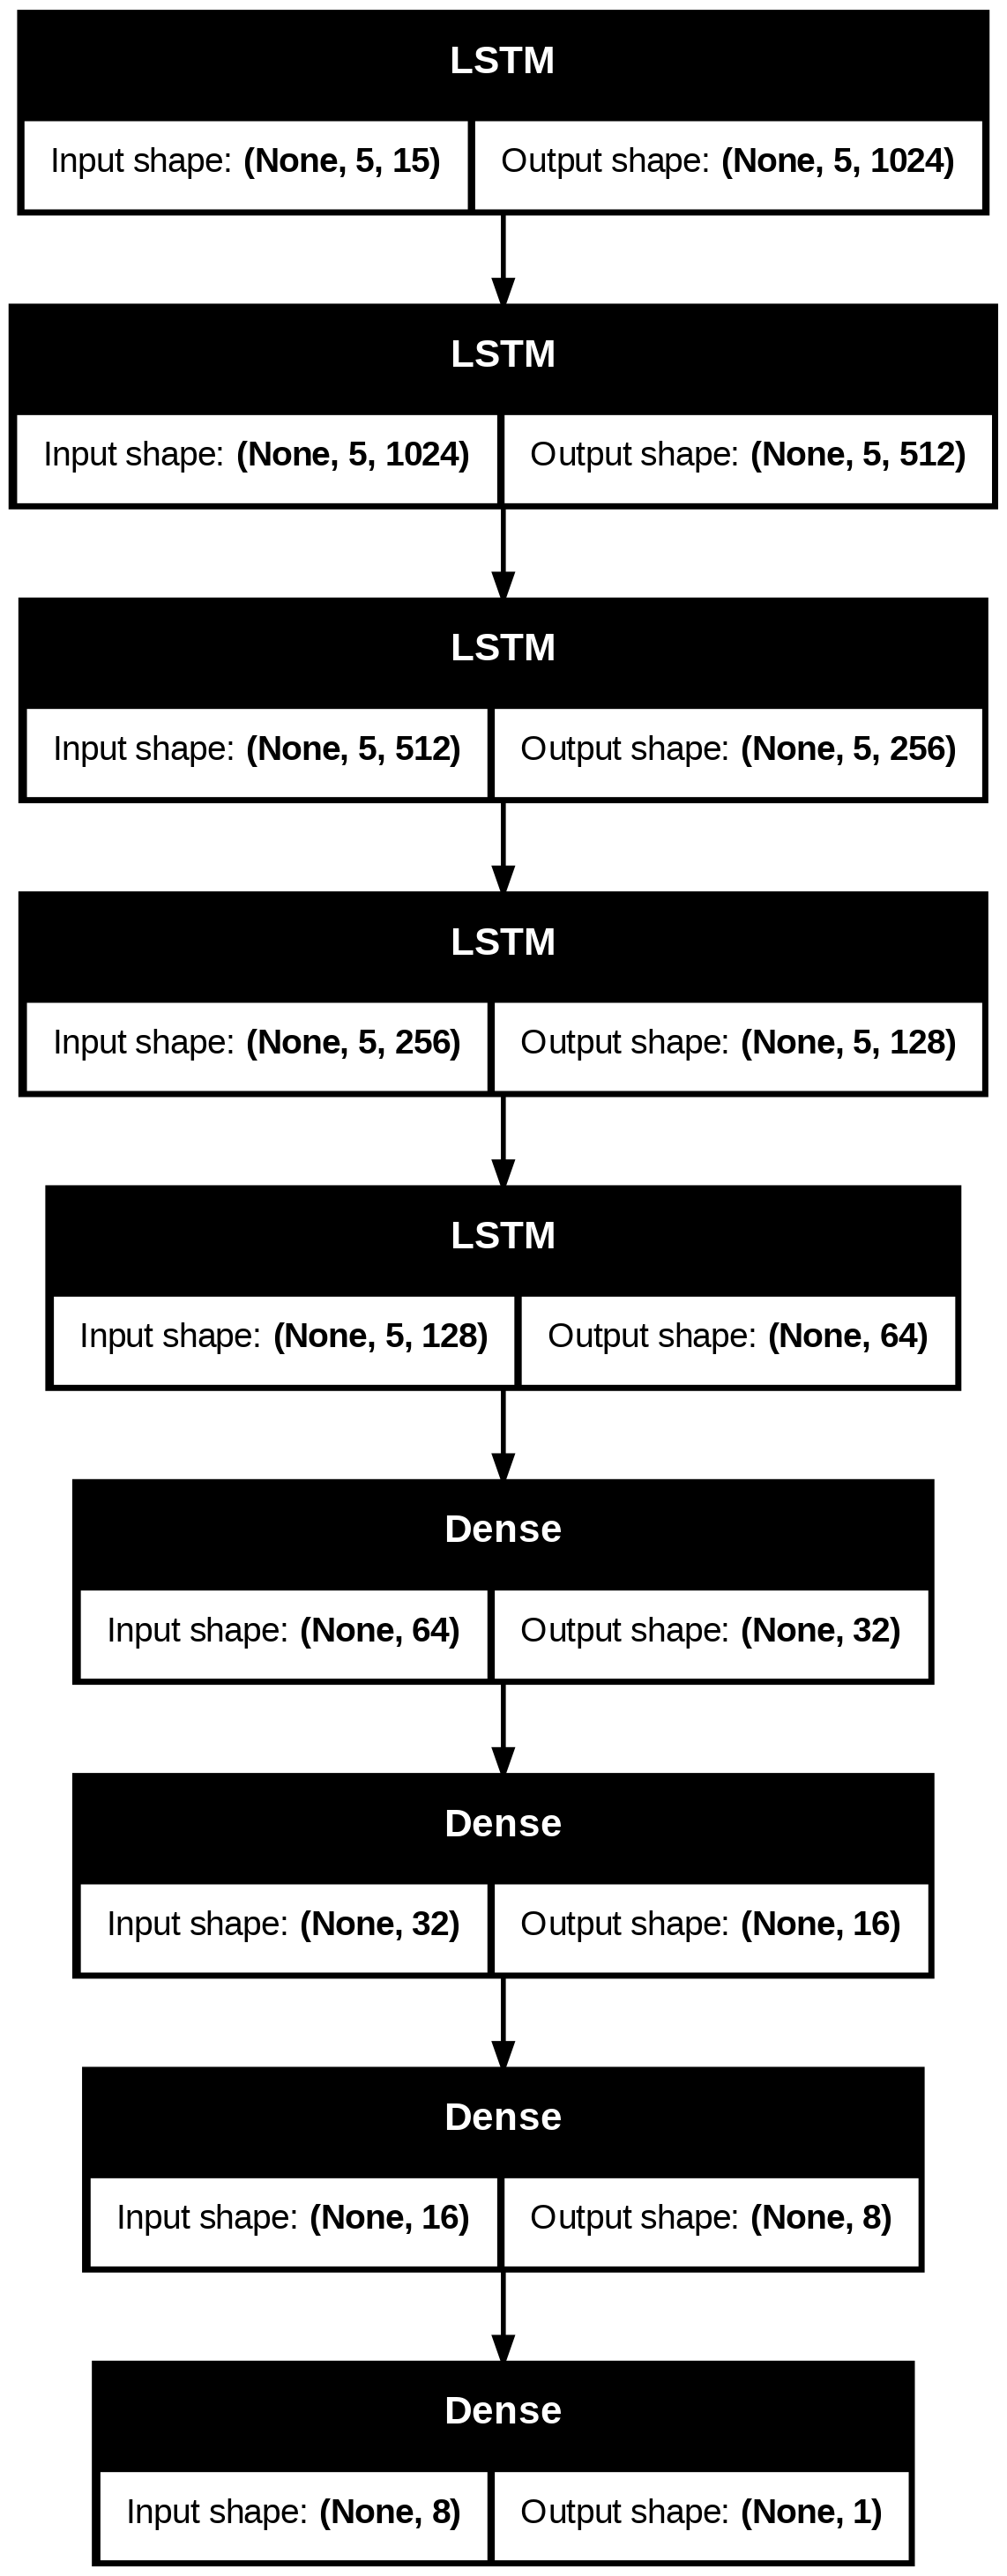

In [93]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

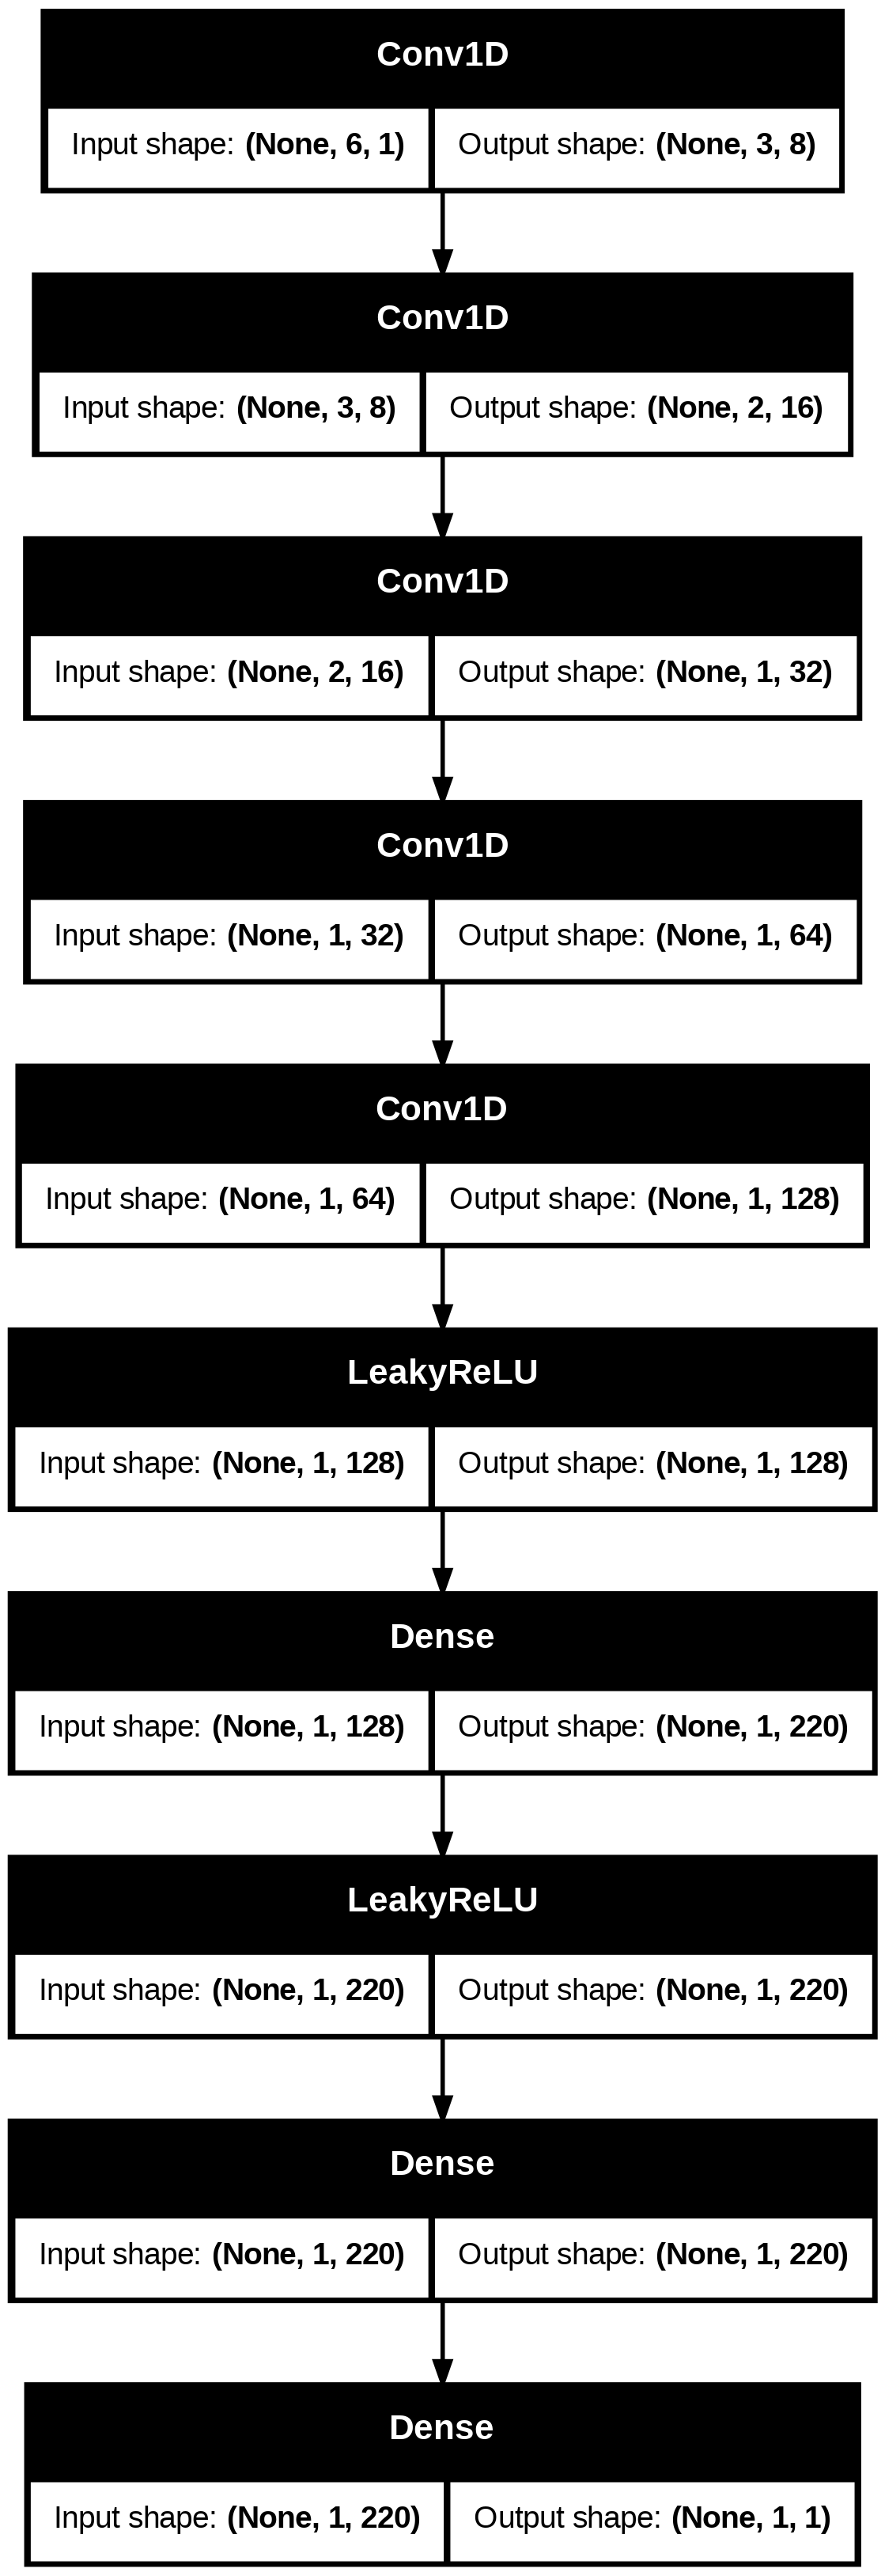

In [49]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

<a id="section-five"></a>
# Train and test model

Train model on train data and save model weights for every 50 epochs:

 10%|█         | 50/500 [02:03<13:41,  1.83s/it]

epoch 50 discriminator_loss 1.4597898 generator_loss 0.6475502


 20%|██        | 100/500 [03:52<18:46,  2.82s/it]

epoch 100 discriminator_loss 1.3077102 generator_loss 0.6957727


 30%|███       | 150/500 [05:35<11:11,  1.92s/it]

epoch 150 discriminator_loss 1.3849198 generator_loss 0.6956121


 40%|████      | 200/500 [07:12<10:40,  2.13s/it]

epoch 200 discriminator_loss 1.3869677 generator_loss 0.6861394


 50%|█████     | 250/500 [09:03<12:28,  3.00s/it]

epoch 250 discriminator_loss 1.386928 generator_loss 0.6919058


 60%|██████    | 300/500 [10:52<07:49,  2.35s/it]

epoch 300 discriminator_loss 1.3863504 generator_loss 0.6932047


 70%|███████   | 350/500 [12:48<06:01,  2.41s/it]

epoch 350 discriminator_loss 1.3861918 generator_loss 0.6919606


 80%|████████  | 400/500 [14:46<04:41,  2.81s/it]

epoch 400 discriminator_loss 1.3862157 generator_loss 0.6928751


 90%|█████████ | 450/500 [16:35<02:10,  2.61s/it]

epoch 450 discriminator_loss 1.385924 generator_loss 0.6975972


100%|██████████| 500/500 [18:21<00:00,  2.20s/it]


epoch 500 discriminator_loss 1.3861814 generator_loss 0.69290257


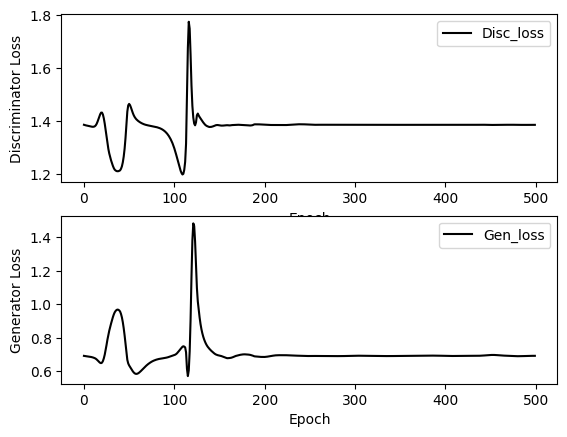

In [94]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [52]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Predict and plot results for test data:

Test RMSE:  6.009692665372114


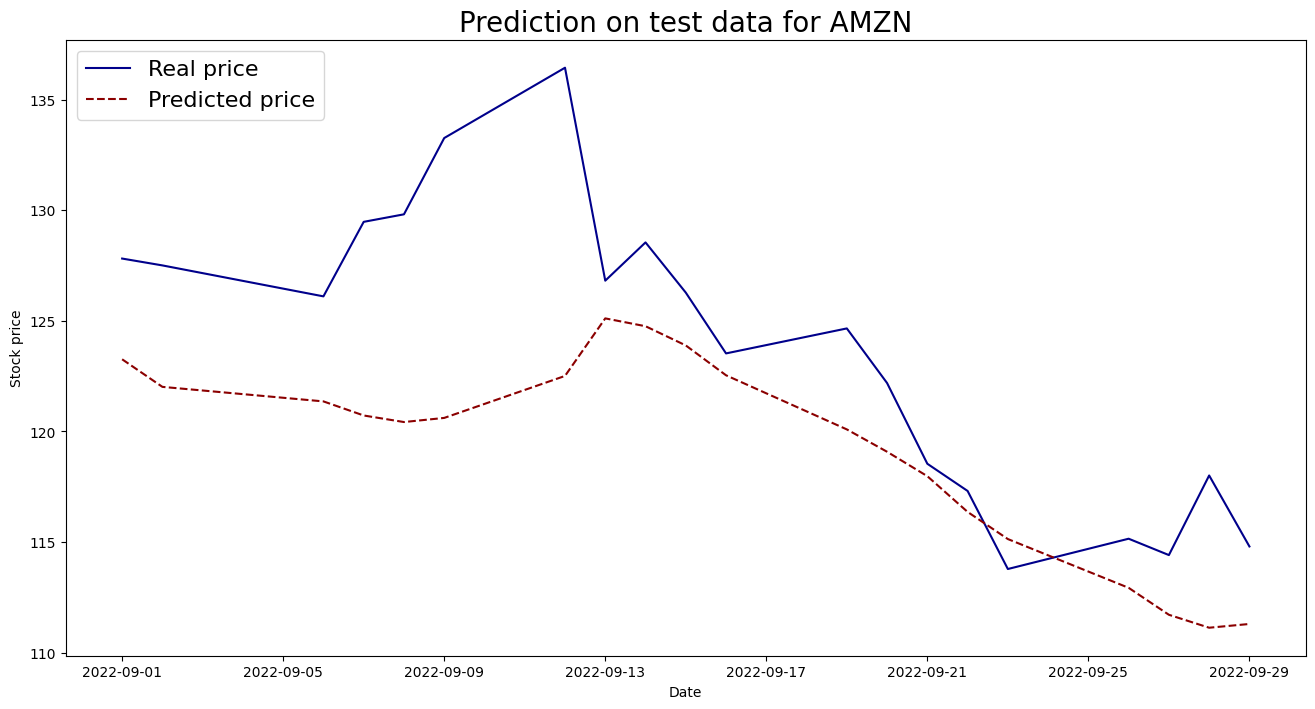

In [53]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

<a id="section-six"></a>
# Conclusions

As we can see, **GAN models** can perform well with time series data, including stock data. Using only raw historical data often results in poor predictions, but when we include technical indicators and **Twitter sentiment analysis**, the model's predictive power improves.

However, this approach may not be as effective for "less popular" stocks since there are fewer tweets about them compared to more well-known stocks like Tesla. In such cases, sentiment scores might not provide a full picture and could even reduce the model's accuracy.